In [38]:
import keras
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import random
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
import time
import random,pickle,cv2
from PIL import Image

In [39]:
graph = tf.get_default_graph()


In [40]:
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

def loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true,y_pred)

def loss2(y_true, y_pred):
    A=y_pred[:,0]*y_true[:,0]
    B=y_pred[:,1]*y_true[:,0]
    a=K.sum(K.square(A-y_true[:,1]))+K.sum(K.square(B-y_true[:,2]))
    return a

#### Load Classification model and function to get classification output as well as convolutional output which is to be fed to regression head

In [41]:
model1=load_model('model3.hdf5', custom_objects={'loss': loss,'f2_score':f2_score})
def create_embedding(model1,x):
    global graph
    with graph.as_default():
            get_3rd_layer_output = K.function([model1.layers[0].input],
                                  [model1.layers[-8].output,model1.layers[-1].output])
            layer_output = get_3rd_layer_output([x])
    return layer_output

#### Load regression head model


In [42]:
model2=load_model('model3regress.hdf5', custom_objects={'loss2': loss2})


#### Pad image to make it's dimensions divisible by 299 and run predictions

In [43]:
 
#
def manipulateImage(img):
    height=299*(1+(img.shape[0]//299))
    width=299*(1+(img.shape[1]//299))
    h=height-img.shape[0]
    w=width-img.shape[1]
    image = cv2.copyMakeBorder( img, h//2, h-(h//2), w//2, w-(w//2), cv2.BORDER_CONSTANT)
    vec=[]
    for x in range(width//299):
        for y in range(height//299):
            vec.append(image[299*y:299*(y+1),299*x:299*(x+1)])
    print(len(vec))
    return np.array(vec)


vec=manipulateImage(img_to_array(load_img('../CV-Assignment-Dataset/DSC02120.JPG'))/255)
output=np.zeros((len(vec),3))
for i in range(len(vec)//30):
    embed,y=create_embedding(model1,vec[i*30:(i+1)*30])
    output[i*30:(i+1)*30,0]=np.squeeze(y)
    output[i*30:(i+1)*30,1:]=model2.predict(embed)
if(len(vec)-1>(i+1)*30):
    embed,y=create_embedding(model1,vec[(i+1)*30:len(vec)])
    output[(i+1)*30:len(vec),0]=np.squeeze(y)
    output[(i+1)*30:len(vec),1:]=model2.predict(embed)
    
i=np.sort(output,axis=0)[::-1,0]
print(i[:10])

294
[0.93789858 0.01449704 0.00798556 0.0079582  0.00769177 0.00768503
 0.00762943 0.00762574 0.00755859 0.00745757]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


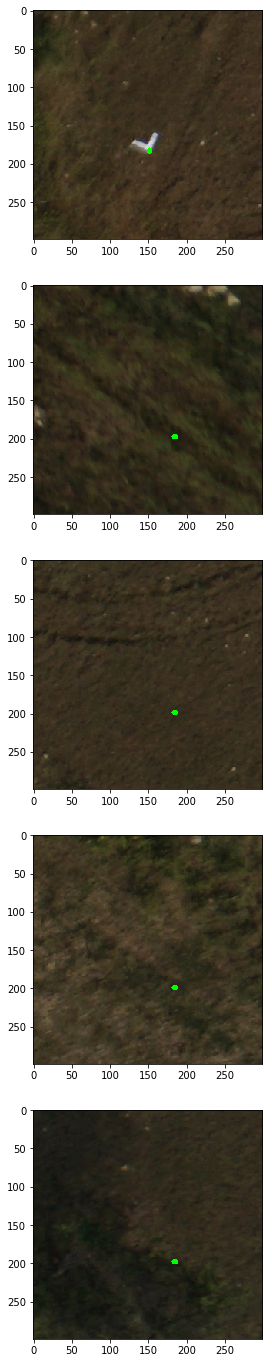

In [44]:
i=np.argsort(output,axis=0)[::-1,0]
f=plt.figure(figsize=(10,75))

for j,x in enumerate(i[:5]):
    f.add_subplot(5,1,j+1)
    cv2.circle(vec[x],tuple(map(int,output[x,1:]*299)),1,(0,255,0),5)
    plt.imshow(vec[x])
    i+=1
